In [2]:
import numpy as np
import pandas as pd
import os
import warnings

In [3]:
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=15.5)    # legend fontsize
plt.rc('figure', titlesize=50)  # fontsize of the figure title

In [30]:
dataset.shape

(100000, 4)

In [27]:
header = ['user_id','item_id','rating','timestamp']
dataset = pd.read_csv('../data/ml-100k/u.data',sep = '\t',names = header)
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
n_items = len(pd.unique(dataset['item_id']))
n_users = len(pd.unique(dataset['user_id']))
n_users, n_items

(943, 1682)

In [7]:
train, test_temp = train_test_split(dataset, test_size=0.2, random_state=42)
val, test = train_test_split(test_temp, test_size=0.5, random_state=42)

In [8]:
model_num = 1000
n_factors = 5
n_nodes_per_layer = [128, 64, 32, 16, 8, 4]
lr = 0.001
dropout_prob = 0.2
epochs = 10
batch_size = 256

# creating item embedding path
movie_input = Input(shape=[1], name="Item-Input")
movie_embedding = Embedding(n_items+1, 5, name="Item-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Items")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([movie_vec, user_vec])

# add fully-connected-layers
dense = Dense(n_nodes_per_layer[0], activation='relu')(conc)
dropout = Dropout(0.2)(dense)
batch_norm = BatchNormalization()(dropout)

for i, n_nodes in enumerate(n_nodes_per_layer[1:-1]):
    # add fully-connected-layers
    dense = Dense(n_nodes, activation='relu')(batch_norm)
    dropout = Dropout(dropout_prob)(dense)
    batch_norm = BatchNormalization()(dropout)

dense = Dense(n_nodes_per_layer[-1], activation='relu')(batch_norm)
out = Dense(1)(dense)

# Create model and compile it
callback = EarlyStopping(monitor='val_loss', patience=3)
model = Model([user_input, movie_input], out)
model.compile(optimizer=Adam(learning_rate=lr), loss=MeanSquaredError())
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 5)         8415        Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User-Input[0][0]                 
______________________________________________________________________________________________

In [9]:
history = model.fit(x = [train.user_id, train.item_id], y = train.rating, validation_data = ((val.user_id, val.item_id), val.rating), epochs=100, verbose=1, batch_size = batch_size, callbacks = [callback])


Epoch 1/100
313/313 [==============================] - 2s 4ms/step - loss: 7.8158 - val_loss: 1.2840
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 1.8640 - val_loss: 1.2394
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 1.4255 - val_loss: 1.2186
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 1.2773 - val_loss: 1.1776
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 1.2099 - val_loss: 1.1247
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1152 - val_loss: 1.0480
Epoch 7/100
313/313 [==============================] - 1s 4ms/step - loss: 1.0463 - val_loss: 1.0099
Epoch 8/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9952 - val_loss: 0.9676
Epoch 9/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9640 - val_loss: 0.9540
Epoch 10/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9385 - val_lo

Text(0.5, 1.0, 'Model 1000: Loss Curves')

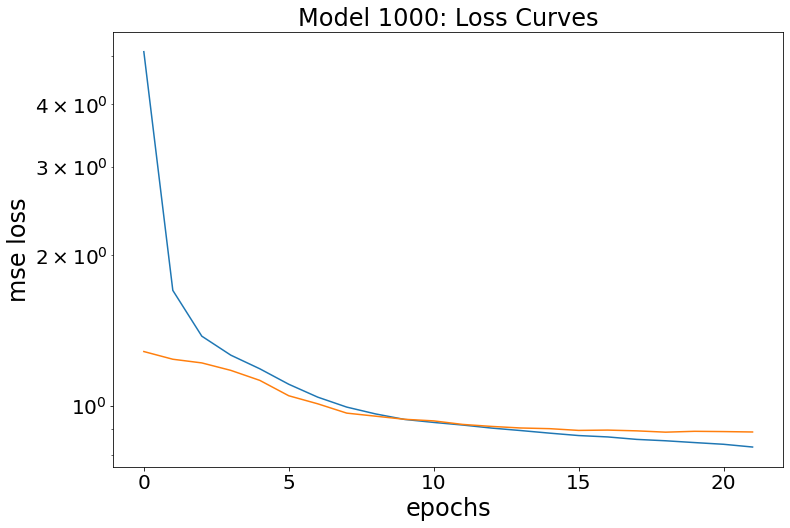

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(train_loss, label = 'train')
plt.plot(val_loss, label = 'val')
plt.yscale('log')
plt.ylabel('mse loss')
plt.xlabel('epochs')
plt.title(f'Model {model_num}: Loss Curves')
# plt.savefig(f'models/model_{model_num}/figures/loss.png')

In [58]:
predictions = model.predict([test.user_id, test.item_id])
preds_std = np.std(predictions)

predictions_list = []
for pred_rating in predictions:
    predictions_list.append(pred_rating[0])
    
ratings_preds_array = np.array(predictions_list).astype('float64')
ratings_actual_array = np.array(test.rating)

test_mse = mean_squared_error(ratings_actual_array, ratings_preds_array)

# make csv with ensemble info
model_info_header_list = ['model', 'test mse', 'test preds std', 'epochs', 'learning rate', 'n_nodes_per_layer', 'n_factors', 'batch_size', 'dropout_prob']
model_info_val_list = [[model_num, test_mse, preds_std, epochs, lr, n_nodes_per_layer, n_factors, batch_size, dropout_prob]]

model_info_df = pd.DataFrame(model_info_val_list, columns = model_info_header_list)

In [59]:
test_mse

0.9681655401867411

In [135]:
import pandas as pd
model_info_all_list = []
for model_num in range(96):
    model_info_df = pd.read_csv(f'models/model_{model_num}/model_info.csv')
    model_info_single_list = list(model_info_df.iloc[0])[1:]
    model_info_all_list.append(model_info_single_list)


In [136]:
model_info_header_list = ['model', 'test mse', 'test preds std', 'epochs', 'learning rate', 'n_nodes_per_layer', 'n_factors', 'batch_size', 'dropout_prob']
model_info_all_df = pd.DataFrame.from_records(model_info_all_list, columns = model_info_header_list)

In [137]:
model_info_all_df.sort_values('test mse')

,model,test mse,test preds std,epochs,learning rate,n_nodes_per_layer,n_factors,batch_size,dropout_prob
49,49,0.874936,0.680089,25,0.010000,"[256, 128, 64, 32, 16, 8, 4, 2]",5,256,0.2
62,62,0.887147,0.568500,25,0.001000,"[256, 128, 64, 32, 16, 8, 4, 2]",50,256,0.2
85,85,0.894681,0.605360,25,0.010000,"[128, 64, 32, 16, 8, 4, 2]",50,256,0.2
73,73,0.895819,0.659334,25,0.010000,"[128, 64, 32, 16, 8, 4, 2]",5,256,0.2
32,32,0.896015,0.641887,25,0.001000,"[512, 256, 128, 64, 32, 16, 8, 4, 2]",25,256,0.2
...,...,...,...,...,...,...,...,...,...
23,23,15.122653,0.147727,25,0.000001,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",100,256,0.2
95,95,15.701981,0.403502,25,0.000001,"[128, 64, 32, 16, 8, 4, 2]",100,256,0.2
53,53,15.923357,0.587195,25,0.000001,"[256, 128, 64, 32, 16, 8, 4, 2]",5,256,0.2
17,17,16.833619,0.392255,25,0.000001,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",50,256,0.2


# Grid Search Analysis

In [7]:
model_info_all_df = pd.read_csv('models/model_info_all.csv')

In [8]:
model_info_all_df.sort_values('test mse')

,Unnamed: 0,model,test mse,test preds std,epochs,learning rate,n_nodes_per_layer,n_factors,batch_size,dropout_prob,patience,early stopping metric
22,22,22,0.877472,5.548574e-01,250,0.0010,"[512, 256, 128, 64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss
5,5,5,0.886648,7.023544e-01,250,0.0100,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
41,41,41,0.888470,5.652527e-01,250,0.0100,"[256, 128, 64, 32, 16, 8, 4, 2]",5,256,0.2,5,val_loss
49,49,49,0.891468,5.828209e-01,250,0.0100,"[256, 128, 64, 32, 16, 8, 4, 2]",50,256,0.2,5,val_loss
11,11,11,0.902415,6.159833e-01,250,0.0001,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",50,256,0.2,5,val_loss
48,48,48,0.905209,6.811764e-01,250,0.1000,"[256, 128, 64, 32, 16, 8, 4, 2]",50,256,0.2,5,val_loss
6,6,6,0.911475,6.475879e-01,250,0.0010,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
29,29,29,0.916098,6.232197e-01,250,0.0100,"[512, 256, 128, 64, 32, 16, 8, 4, 2]",50,256,0.2,5,val_loss
7,7,7,0.916653,5.753726e-01,250,0.0001,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",25,256,0.2,5,val_loss
57,57,57,0.917084,7.627777e-01,250,0.0100,"[256, 128, 64, 32, 16, 8, 4, 2]",200,256,0.2,5,val_loss


# Gather predicted ratings per user

In [11]:
user_item_pairs_list = []
for i in range(n_users):
    for j in range(n_items):
        user_item_pairs_list.append([i,j])
user_item_pairs_array = np.transpose(np.array(user_item_pairs_list))

In [12]:
users_in_user_item_pairs = np.array(user_item_pairs_list)[:,0].reshape(-1,1)
items_in_user_item_pairs = np.array(user_item_pairs_list)[:,1].reshape(-1,1)

In [11]:
userID = 340
single_user_all_items_pairs_list = []
for i in range(n_items):
    single_user_all_items_pairs_list.append([userID, i])

users_in_single_user_all_items_pairs = np.array(single_user_all_items_pairs_list)[:,0].reshape(-1,1)
items_in_single_user_all_items_pairs = np.array(single_user_all_items_pairs_list)[:,1].reshape(-1,1)
all_predictions = model.predict([users_in_single_user_all_items_pairs, items_in_single_user_all_items_pairs])

In [20]:
items_in_single_user_all_items_pairs

array([[   0],
       [   1],
       [   2],
       ...,
       [1679],
       [1680],
       [1681]])

In [32]:
items_in_single_user_all_items_pairs[0][0]

0

In [25]:
res = [(float(all_predictions[i]), int(items_in_single_user_all_items_pairs[i])) for i in range(len(items_in_single_user_all_items_pairs))]

In [36]:
res.sort(reverse = True)

In [37]:
res

[(4.4298176765441895, 1642),
 (4.391163349151611, 867),
 (4.388373374938965, 1639),
 (4.3876471519470215, 320),
 (4.382619857788086, 1449),
 (4.372637748718262, 114),
 (4.370509624481201, 1653),
 (4.367603302001953, 318),
 (4.35577392578125, 64),
 (4.321097373962402, 50),
 (4.319510459899902, 1500),
 (4.317525863647461, 483),
 (4.312206268310547, 1367),
 (4.308260440826416, 1293),
 (4.305779933929443, 603),
 (4.304959774017334, 1650),
 (4.3042473793029785, 913),
 (4.302768707275391, 12),
 (4.30225133895874, 1612),
 (4.298708915710449, 1398),
 (4.295374870300293, 480),
 (4.293142795562744, 408),
 (4.289042949676514, 316),
 (4.287353992462158, 127),
 (4.284982204437256, 178),
 (4.2842278480529785, 427),
 (4.280398368835449, 134),
 (4.278439998626709, 474),
 (4.277455806732178, 1651),
 (4.276456356048584, 174),
 (4.275817394256592, 98),
 (4.2647881507873535, 357),
 (4.263087749481201, 272),
 (4.260168552398682, 1169),
 (4.25685453414917, 515),
 (4.2543745040893555, 191),
 (4.2538132667541

In [55]:
all_predictions = model.predict([users_in_user_item_pairs, items_in_user_item_pairs])

In [14]:
ratings_per_user_dict = {}
test_user_id_list = list(test.user_id)
test_item_id_list = list(test.item_id)
unique_user_id_list = list(np.unique(test.user_id))
for i in range(len(unique_user_id_list)):
    ratings_per_user_dict[unique_user_id_list[i]] = []

    
for i in range(len(test.user_id)):
    ratings_per_user_dict[test_user_id_list[i]].append((test_item_id_list[i], ratings_preds_array[i]))

In [22]:
ratings_per_user_dict

{1: [(159, 2.6085562705993652),
  (153, 3.844974994659424),
  (254, 2.3931310176849365),
  (77, 2.8856253623962402),
  (256, 3.9061965942382812),
  (136, 4.009044647216797),
  (267, 2.70483136177063),
  (186, 3.7372207641601562),
  (192, 3.9973411560058594),
  (32, 3.8787026405334473),
  (31, 3.419355869293213),
  (265, 3.8610732555389404),
  (26, 3.262843608856201),
  (217, 2.7787179946899414),
  (8, 3.8477516174316406),
  (156, 3.996884346008301),
  (64, 4.088481426239014),
  (94, 2.3931310176849365),
  (181, 3.907043695449829),
  (245, 2.396407127380371),
  (66, 3.3402926921844482),
  (220, 2.5046634674072266),
  (141, 3.5471253395080566),
  (119, 4.178868770599365),
  (118, 2.554379940032959),
  (157, 3.7268295288085938),
  (206, 3.104708194732666),
  (82, 3.7468771934509277),
  (158, 2.3931310176849365),
  (263, 2.3931310176849365),
  (142, 2.7946784496307373),
  (1, 3.8763394355773926),
  (238, 3.7515907287597656),
  (100, 4.038003444671631),
  (193, 3.9275450706481934)],
 2: [(2

In [19]:
top_n = 5

sorted(ratings_per_user_dict[340], key = lambda x: x[1], reverse = True)[:top_n]

[(174, 3.9678072929382324),
 (173, 3.9067201614379883),
 (196, 3.8937885761260986),
 (1, 3.88016939163208),
 (211, 3.8553123474121094)]